In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import math
from population_geojson import create_pop_geojson
from model_dev import prepare_data, compare_models_logo, compare_models_logo_warnings
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import clone
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning






# Analysis Part 2: Predicting Populations in the Yukon
### Using OSM data from other provinces/territories

Extending the analysis from part 1 (based on the work done by [Diego Matos Chavez (2020)](https://medium.com/data-science/estimating-the-population-of-arbitrarily-chosen-areas-533e81c2104e)), we will incorporate data from other provinces and territories to predict populations in Yukon. This will allow us to use more robust modelling and cross-validation techniques. 

## Gathering data

Provinces and territories most similar to Yukon were selected for analysis. Unfortunately, data from Ontario and Alberta was not compatible with the OSM feature extractor tool. Thus, data from BC, Nunavut, the Northwest Territories, and Saskatchewan was used. 

In [12]:
merged_inner_bc = create_pop_geojson("British Columbia", 
                                     2021, 
                                     "Data/17100155-eng/17100155.csv", 
                                     "Data/all_georef-canada-province@public.geojson", 
                                     "Data/all_georef-canada-census-subdivision@public.geojson")

In [21]:
merged_inner_northwest_territories = create_pop_geojson("Northwest Territories", 
                                     2021, 
                                     "Data/17100155-eng/17100155.csv", 
                                     "Data/all_georef-canada-province@public.geojson", 
                                     "Data/all_georef-canada-census-subdivision@public.geojson")

(41, 29)

In [77]:
merged_inner_saskatchewan = create_pop_geojson("Saskatchewan", 
                                     2021, 
                                     "Data/17100155-eng/17100155.csv", 
                                     "Data/all_georef-canada-province@public.geojson", 
                                     "Data/all_georef-canada-census-subdivision@public.geojson")
                                     

In [79]:
merged_inner_nunavut = create_pop_geojson("Nunavut", 
                                     2021, 
                                     "Data/17100155-eng/17100155.csv", 
                                     "Data/all_georef-canada-province@public.geojson", 
                                     "Data/all_georef-canada-census-subdivision@public.geojson")
                                     

In [89]:
merged_inner_yukon = create_pop_geojson("Yukon", 
                                     2021, 
                                     "Data/17100155-eng/17100155.csv", 
                                     "Data/all_georef-canada-province@public.geojson", 
                                     "Data/all_georef-canada-census-subdivision@public.geojson")

Next, the OSM feature extractor tool was used (command-line). Note that for some reason, the Alberta and Ontario data was not able to be processed. In the interest of time, this data was disregarded for the analysis. 

In [18]:
# Combine outputs into one df 
bc_gdf = gpd.read_file("Data/bc_osm_extractor_output")
bc_gdf["Province"] = "BC"
nunavut_gdf = gpd.read_file("Data/nunavut_osm_extractor_output")
nunavut_gdf["Province"] = "Nunavut"
sask_gdf = gpd.read_file("Data/saskatchewan_osm_extractor_output")
sask_gdf["Province"] = "Saskatchewan"
nwt_gdf = gpd.read_file("Data/nwt_osm_extractor_output")
nwt_gdf["Province"] = "NWT"
yukon_gdf = gpd.read_file("Data/osm_extractor_output")
yukon_gdf["Province"] = "Yukon"




In [20]:
# Identify duplicates in csd_name_en
duplicates = yukon_gdf[yukon_gdf.duplicated(subset=["csd_name_en"], keep=False)]

# Add suffix to csd_name_en for duplicates
yukon_gdf["csd_name_en"] = yukon_gdf.apply(
    lambda row: f"{row['csd_name_en']} ({row['csd_type']})" 
    if row["csd_name_en"] in duplicates["csd_name_en"].values else row["csd_name_en"],
    axis=1
)
yukon_gdf["csd_name_en"]


0                                        Faro
1                                      Tagish
2                                  Ross River
3     Whitehorse (Unorganized / Non organisé)
4                             Haines Junction
5                                Beaver Creek
6                                       Yukon
7                                 Ibex Valley
8                                   Mt. Lorne
9                              Lake Laberge 1
10                                     Dawson
11                                Upper Liard
12                          Whitehorse (City)
13                            Burwash Landing
14                             Teslin Post 13
15                       Champagne Landing 10
16                                  Keno Hill
17                                       Mayo
18                          Johnsons Crossing
19                                   Carcross
20                       Teslin (Teslin land)
21                           Tesli

In [21]:
complete_df = pd.concat([bc_gdf, nunavut_gdf, sask_gdf, nwt_gdf, yukon_gdf])
complete_df = complete_df[complete_df["Subdivision"] != "Yukon"]



In [10]:
# Correlations
# Calculate correlations with the target
correlations = complete_df.corr(numeric_only=True)["population"].sort_values(ascending=False)
# Drop population, since correlation will be 1. 
correlations = correlations.drop(index=["population", "VALUE", "COORDINATE"])
# Convert to DF for plotting
correlations_df = correlations.reset_index()
correlations_df.dropna(inplace=True)
correlations_df.columns = ["Feature", "Correlation"]
correlations_df

,Feature,Correlation
0,highway_traffic_signals_count,0.965440
1,building_civic_area,0.960769
2,shop_general_store_count,0.954825
3,amenity_financial_count,0.942661
4,landuse_retail_area,0.942645
...,...,...
111,leisure_area,0.002660
112,railway_other_length,-0.001366
113,military_area,-0.003039
114,natural_length,-0.003869


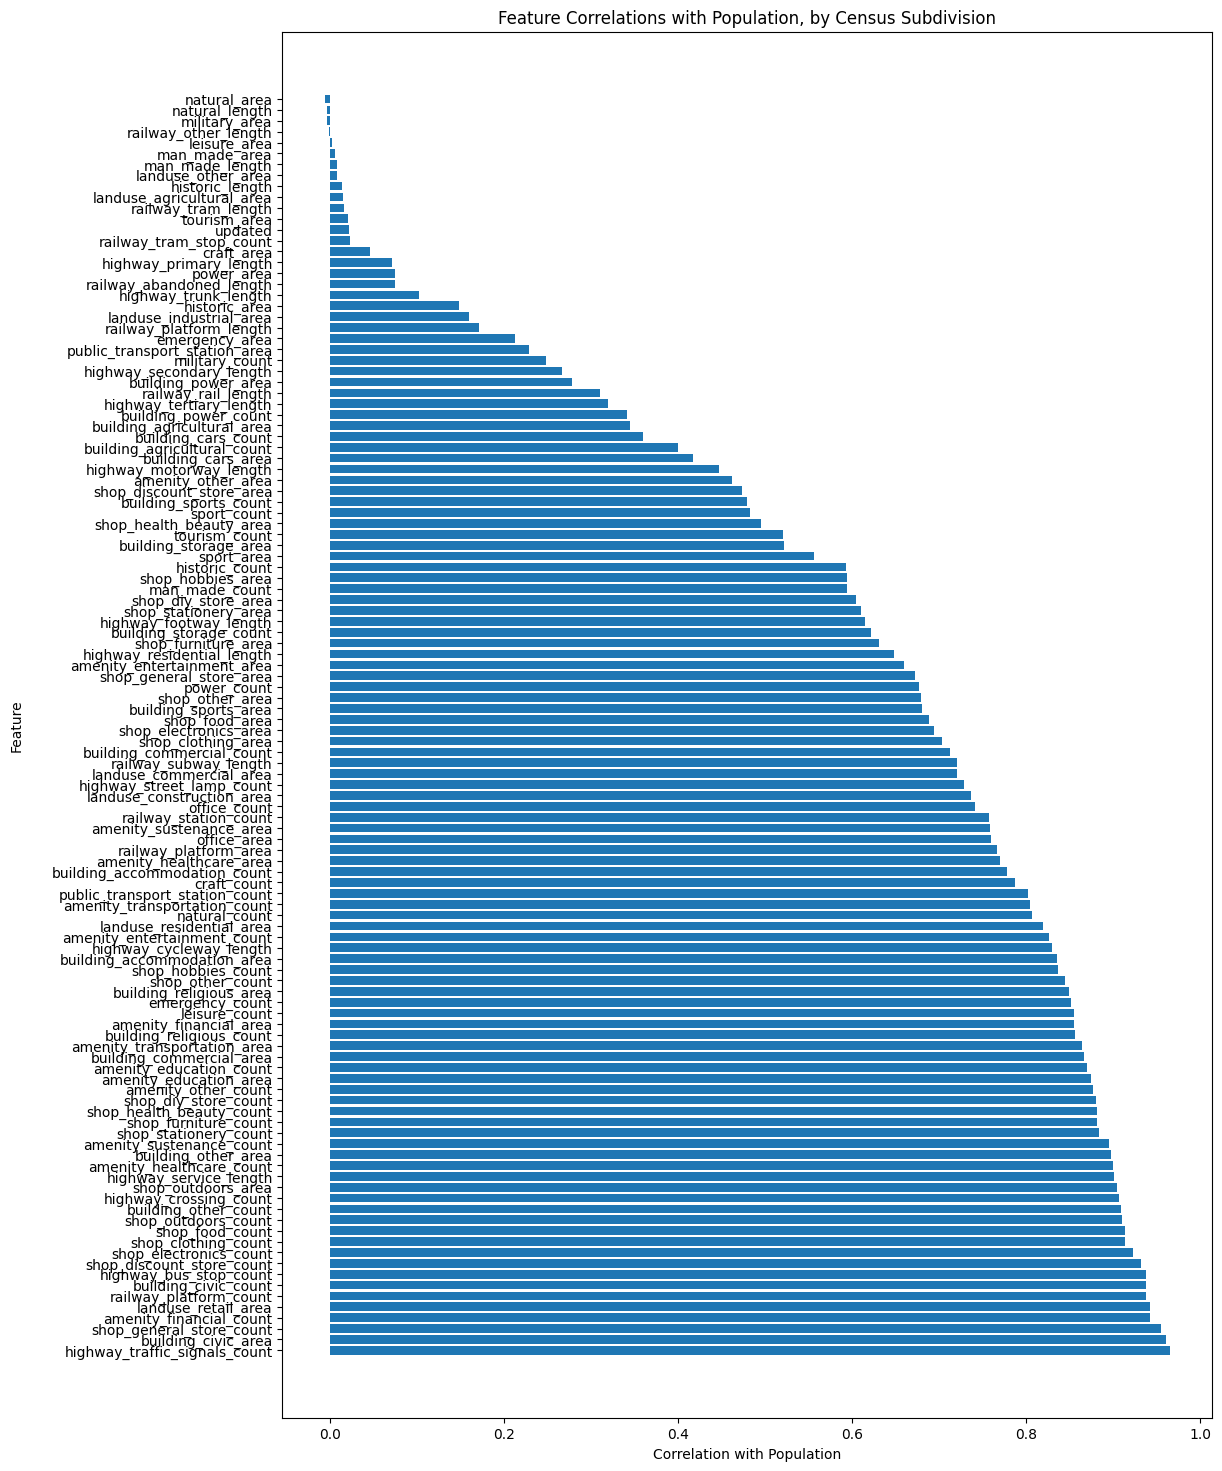

In [6]:
fig, ax = plt.subplots(figsize=(12, 18))

ax.barh(correlations_df["Feature"], correlations_df["Correlation"], height=0.8)
plt.xlabel("Correlation with Population")
plt.ylabel("Feature")
plt.title("Feature Correlations with Population, by Census Subdivision")
# Increase space between y-axis ticks
ax.yaxis.labelpad = 20  # Adjust this value as needed

plt.show()

In [7]:
def make_scatterplots(df, target_var):
    """Makes scatterplots comparing each variable in df to target_var.
    Parameters:
        df: geodf
        target_var: name of target, string
    """
    features = [col for col in df.columns if col!= target_var and col != "Subdivision"]
    rows = math.ceil(len(features)/4)
    fig, axes = plt.subplots(rows, 4, figsize=(4*5, rows*4), constrained_layout=True)
    axes=axes.flatten()
    for i, feature in enumerate(features):
        ax = axes[i]
        ax.scatter(df[feature], df[target_var], alpha=0.7, edgecolor='k')
        ax.set_title(f"{feature} vs {target_var}", fontsize=10)
        ax.set_xlabel(feature, fontsize=8)
        ax.set_ylabel(target_var, fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.5)
    plt.suptitle(f"Scatter Plots: Features vs {target_var}", fontsize=16)
    plt.show()

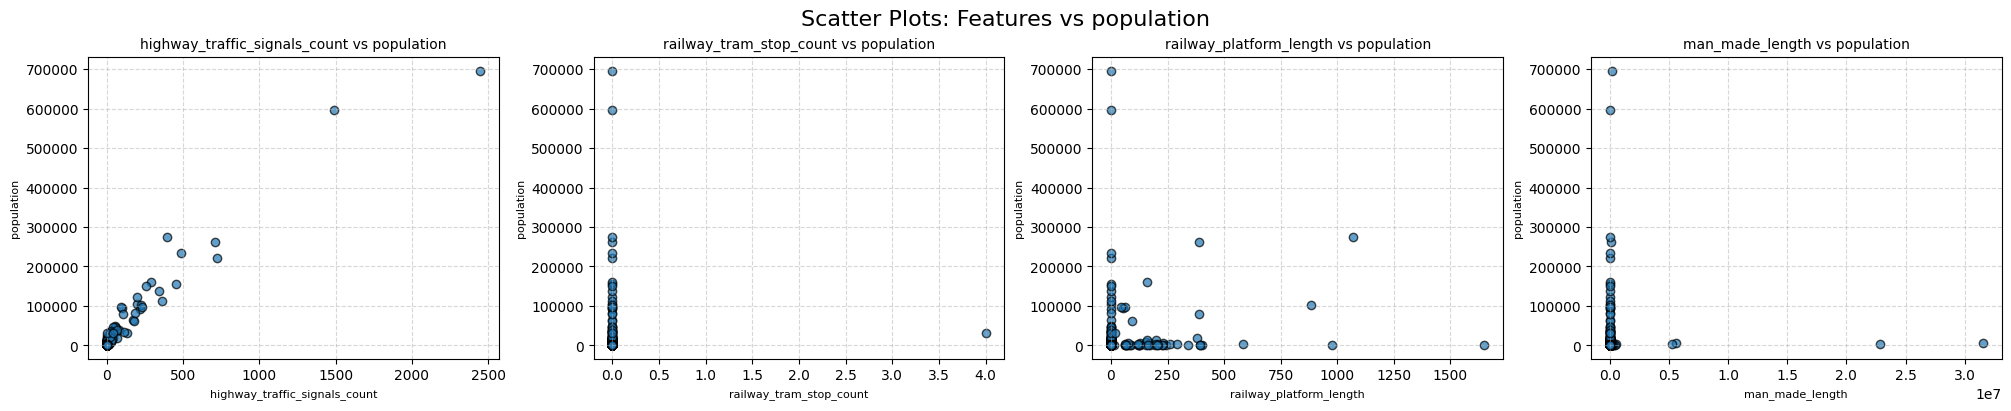

In [8]:
subset = complete_df[["highway_traffic_signals_count", "railway_tram_stop_count", "railway_platform_length", "man_made_length", "population"]]


make_scatterplots(subset, "population")

## Model Development

### Cross-validation for autocorrelated data

Cross validation is technique to evaluate performance of a model by splitting the data into *independent* subsets for training and testing. In other words, typical random assignment of observations to the training and testing sets assumes that the target variable (in our case, population density) is uniformally distributed. However, we know that the populations of two places that are near to each other are likely more related than the populations of two places that are far from each other. In geography, this concept is called Tobler's Law: everything is related to everything else, but near things are more related than distant things. This property of spatial data necessitates a different approach to data splitting. 

A typical approach is to group data by area (in our case, province/territory) and assign entire areas to the training or testing sets. Given our end goal of predicting population in the Yukon, we will hold out this data in training, and this entire territory will comprise the test set. Therefore, the training set will be composed of data from British Columbia, Nunavut, Saskatchewan, the Nortwest Territories, and Ontario. Within the model training process, we will implement **Leave-One-Group-Out CV**. As the name suggests, this method excludes one "group" (province/territory) within each training fold.


In [22]:
gdf_train = complete_df[complete_df["Province"]!="Yukon"]
gdf_test = complete_df[complete_df["Province"]=="Yukon"]

In [9]:
for col in gdf_test.columns:
    print(col)

geo_point_2d
year
prov_code
prov_name_en
cd_code
cd_name_en
csd_code
csd_name_en
csd_area_code
csd_type
prov_name_fr
cd_name_fr
csd_name_fr
REF_DATE
GEO
DGUID
UOM
UOM_ID
SCALAR_FACTOR
SCALAR_ID
VECTOR
COORDINATE
VALUE
STATUS
SYMBOL
TERMINATED
DECIMALS
population
updated
highway_traffic_signals_count
highway_street_lamp_count
highway_bus_stop_count
highway_traffic_calming_count
highway_crossing_count
office_count
railway_tram_stop_count
public_transport_station_count
railway_platform_count
railway_station_count
emergency_count
power_count
shop_health_beauty_count
shop_diy_store_count
shop_general_store_count
shop_furniture_count
shop_food_count
shop_electronics_count
shop_outdoors_count
shop_other_count
shop_hobbies_count
shop_clothing_count
shop_stationery_count
shop_discount_store_count
natural_count
leisure_count
military_count
historic_count
sport_count
tourism_count
man_made_count
building_other_count
building_accommodation_count
building_civic_count
building_storage_count
building

In [12]:
temp = gdf_test[gdf_test["csd_name_en"] == "Whitehorse"]
temp

,geo_point_2d,year,prov_code,prov_name_en,cd_code,cd_name_en,csd_code,csd_name_en,csd_area_code,csd_type,...,amenity_education_area,amenity_other_area,amenity_healthcare_area,amenity_transportation_area,amenity_entertainment_area,amenity_financial_area,craft_area,geometry,Province,Subdivision
3,"{ ""lon"": -135.04660847453101, ""lat"": 60.546525...",2021,60,Yukon,6001,Yukon,6001060,Whitehorse,CAN,Unorganized / Non organisé,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,"POLYGON ((-134.2056 60.67932, -134.47184 60.81...",Yukon,Whitehorse
12,"{ ""lon"": -135.06730406577145, ""lat"": 60.702889...",2021,60,Yukon,6001,Yukon,6001009,Whitehorse,CAN,City,...,395558.89,17166.27,132785.59,6056.08,18448.8,2731.72,799.81,"POLYGON ((-134.96488 60.74964, -135.08144 60.8...",Yukon,Whitehorse


In [7]:
# Regression
cols_to_remove = ["geo_point_2d",
"year", 
"prov_code",
"prov_name_en",
"cd_code",
"cd_name_en",
"csd_code",
"csd_name_en",
"csd_area_code",
"csd_type",
"prov_name_fr",
"cd_name_fr",
"csd_name_fr",
"REF_DATE",
"GEO",
"DGUID",
"UOM",
"UOM_ID",
"SCALAR_FACTOR",
"SCALAR_ID",
"VECTOR",
"COORDINATE",
"VALUE",
"STATUS",
"SYMBOL",
"TERMINATED",
"DECIMALS",
"updated", 
"geometry",
"Province",
"Subdivision"]

gdf_norm, areas, subdivisions = prepare_data(gdf_train, cols_to_remove, crs='epsg:3857')

In [8]:


regressors = {
    'LinearRegression': LinearRegression(),
    'RidgeCV': RidgeCV(alphas=[0.1, 1, 10, 100]),
    'LassoCV': LassoCV(alphas=[0.1, 1, 10, 100], max_iter=10000),
    'ElasticNetCV': ElasticNetCV(alphas=[0.1, 1, 10, 100],
                                 l1_ratio=[0.1, 0.5, 0.9], max_iter=10000),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                                   max_depth=3, random_state=42)
}

logo = LeaveOneGroupOut()



In [9]:
# Suppress warnings only in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)  # Suppress UserWarnings
    warnings.simplefilter("ignore", category=ConvergenceWarning)  # Suppress ConvergenceWarnings

    # Call the function
    best_model, best_params, results_df = compare_models_logo_warnings(regressors, gdf_norm, degrees=[1, 2], cv_strategy=logo)

Evaluated LinearRegression with degree 1 => MAE: 428.972479047749 (current best: inf)
  → Updating best model to LinearRegression (degree 1) with MAE 428.972479047749
Evaluated RidgeCV with degree 1 => MAE: 181.2047909472362 (current best: 428.972479047749)
  → Updating best model to RidgeCV (degree 1) with MAE 181.2047909472362
Evaluated LassoCV with degree 1 => MAE: 41.24755913396164 (current best: 181.2047909472362)
  → Updating best model to LassoCV (degree 1) with MAE 41.24755913396164
Evaluated ElasticNetCV with degree 1 => MAE: 121.40883222888634 (current best: 41.24755913396164)
Evaluated RandomForest with degree 1 => MAE: 38.49972236751044 (current best: 41.24755913396164)
  → Updating best model to RandomForest (degree 1) with MAE 38.49972236751044
Evaluated GradientBoosting with degree 1 => MAE: 41.588160988118744 (current best: 38.49972236751044)
Evaluated LinearRegression with degree 2 => MAE: 6501391986.513547 (current best: 38.49972236751044)
Evaluated RidgeCV with degre

In [10]:
results_df.sort_values(by="MAE")

,Model,Degree,MAE,Warning
10,RandomForest,2,3.759680e+01,None
4,RandomForest,1,3.849972e+01,None
11,GradientBoosting,2,4.082901e+01,None
2,LassoCV,1,4.124756e+01,None
5,GradientBoosting,1,4.158816e+01,None
8,LassoCV,2,5.977956e+01,Objective did not converge. You might want to ...
9,ElasticNetCV,2,9.320904e+01,Objective did not converge. You might want to ...
3,ElasticNetCV,1,1.214088e+02,None
1,RidgeCV,1,1.812048e+02,None
0,LinearRegression,1,4.289725e+02,None


In [9]:
print(best_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])


In [10]:
gdf_norm_test, areas_test, subdivisions_test = prepare_data(gdf_test, cols_to_remove, crs='epsg:3857')

X_yukon = gdf_norm_test.drop(columns=["population_density", "Province"])  # Drop target and Province
y_yukon = gdf_norm_test["population_density"]  # Target variable

In [11]:
best_model.fit(X_yukon, y_yukon)
y_yukon_pred = best_model.predict(X_yukon)
y_yukon_actual = gdf_norm_test["population_density"]
# Calculate MAE and MSE
mae = mean_absolute_error(y_yukon_actual, y_yukon_pred)
mse = mean_squared_error(y_yukon_actual, y_yukon_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 1.5106145761055176
Mean Squared Error (MSE): 8.555665791436546


In [12]:
pred_yukon_counts = y_yukon_pred * areas_test
actual_counts = gdf_test[gdf_test["Subdivision"]!="Yukon"]["population"]  
pred_df = {"Subdivision": subdivisions_test, 
           "Predicted": pred_yukon_counts.round(2), 
           "Actual": actual_counts}
pred_df = pd.DataFrame(pred_df)
pred_df["AbsDifference"] = round(abs(pred_df["Predicted"] - pred_df["Actual"]), 2)
pred_df = pred_df.sort_values(by="AbsDifference", ascending=False)
pred_df


,Subdivision,Predicted,Actual,AbsDifference
12,Whitehorse,21899.38,30269.0,8369.62
3,Whitehorse,25607.27,30269.0,4661.73
22,Macpherson-Grizzly Valley,5080.11,1532.0,3548.11
8,Mt. Lorne,1419.35,466.0,953.35
27,Marsh Lake,1491.97,744.0,747.97
29,Watson Lake,1577.49,1051.0,526.49
10,Dawson,1477.99,1728.0,250.01
4,Haines Junction,921.22,785.0,136.22
7,Ibex Valley,596.29,499.0,97.29
16,Keno Hill,105.57,21.0,84.57
